In [1]:
# bibliotecas
import scipy.io
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

In [2]:
# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_csv('turbidez_classes.csv', delimiter=';')
df_mask = data['Dominio'] == 'Estados_Unidos'
data = data[df_mask]
df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()
# filtrar so para bandas e classe
df = df_filtro[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12','Classe']]
df['Classe'] = df['Classe'] - 1
df

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
0,115.0,177.0,168.0,86.0,74.0,32.0,52.0,32.0,26.0,17.0,40.0,36.0,0
1,468.0,385.0,354.0,278.0,299.0,300.0,327.0,279.0,302.0,551.0,253.0,177.0,0
2,524.0,598.0,670.0,501.0,597.0,561.0,583.0,811.0,586.0,1638.0,529.0,345.0,0
3,611.0,667.0,649.0,589.0,610.0,664.0,694.0,680.0,648.0,462.0,557.0,451.0,0
4,468.0,385.0,354.0,278.0,299.0,300.0,327.0,279.0,302.0,551.0,253.0,177.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819,962.0,1214.0,1705.0,2225.0,2617.0,2949.0,3066.0,3088.0,3117.0,2693.0,3364.0,3019.0,3
5820,524.0,598.0,670.0,501.0,597.0,561.0,583.0,811.0,586.0,1638.0,529.0,345.0,3
5821,197.0,199.0,293.0,194.0,147.0,50.0,50.0,33.0,40.0,11.0,66.0,53.0,3
5822,224.0,275.0,299.0,167.0,256.0,312.0,373.0,283.0,307.0,665.0,114.0,114.0,3


In [3]:
# contar classes
print('Quantidade por classe:')
print(df['Classe'].value_counts())

# filtrar por classe
df_1 = df[df['Classe']==0]
df_2 = df[df['Classe']==1]
df_3 = df[df['Classe']==2]
df_4 = df[df['Classe']==3]
#df_5 = df[df['Classe']==5]
#df_6 = df[df['Classe']==6]

Quantidade por classe:
0    3744
1     160
3      37
2      26
Name: Classe, dtype: int64


In [4]:
# deixar classe 0 como sendo anomalia e o o resto como normal
df_anomalia = pd.concat([df_2, df_3, df_4])
df_normal = df_1
df_anomalia.loc[:,'Classe'] = 1
df_normal.loc[:,'Classe'] = 0

print('Quantidade por classe:')
print(df_normal['Classe'].value_counts())
print(df_anomalia['Classe'].value_counts())

Quantidade por classe:
0    3744
Name: Classe, dtype: int64
1    223
Name: Classe, dtype: int64


In [5]:
#separar treino e teste
qtd_amostras_treino = 3744-223

randomlist = random.sample(range(0, df_normal.shape[0]), qtd_amostras_treino)
df_normal_train = df_normal.iloc[randomlist]
df_normal_test = df_normal.drop(df_normal.index[randomlist])

df_anomalia_test = df_anomalia

print('Classe 1 - treino:', df_normal_train.shape[0], '/ teste:', df_normal_test.shape[0])
print('Classe 2 - teste:', df_anomalia_test.shape[0])

Classe 1 - treino: 3521 / teste: 223
Classe 2 - teste: 223


In [6]:
# concatenar dataframes
df_train = df_normal_train
frames_test = [df_normal_test, df_anomalia_test]
df_test = pd.concat(frames_test)
#print('Tamanho train:', df_train.shape)
#print('Tamanho test:', df_test.shape)

# separar entrada e rotulo do treino e teste
X_train = df_train.to_numpy()[:,:12]
y_train = df_train.to_numpy()[:,12].astype(int)
X_test = df_test.to_numpy()[:,:12]
y_test = df_test.to_numpy()[:,12].astype(int)

print('Tamanho train:', X_train.shape, '/ rotulos:', y_train.shape)
print('Tamanho test:', X_test.shape, '/ rotulos:', y_test.shape)

Tamanho train: (3521, 12) / rotulos: (3521,)
Tamanho test: (446, 12) / rotulos: (446,)


In [7]:
#padronizando dados antes do treinamento
scaler = StandardScaler()

norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.transform(X_test)

In [ ]:
'''# pca

import plotly.express as px
from sklearn.decomposition import PCA

X = df.loc[:, df.columns != 'Classe']

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['Classe'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

# SVM One Class

In [9]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']
nu = [0.01, 0.1, 0.5, 0.8, 0.99]

resultados_svm = []

for a in tqdm(kernel):
    for b in gamma:
        for c in nu:
            grid_svm = OneClassSVM(kernel=a, gamma=b, nu=c)
            grid_svm.fit(norm_X_train)
            grid_svm_predictions = grid_svm.predict(norm_X_test)
            grid_svm_predictions[grid_svm_predictions == 1] = 0
            grid_svm_predictions[grid_svm_predictions == -1] = 1
            #print('Acuracia: ', accuracy_score(y_test, grid_svm_predictions),'\n')
            resultados_svm.append(a)
            resultados_svm.append(b)
            resultados_svm.append(c)
            resultados_svm.append(accuracy_score(y_test, grid_svm_predictions))
            resultados_svm.append(precision_score(y_test, grid_svm_predictions))
            resultados_svm.append(recall_score(y_test, grid_svm_predictions))
            resultados_svm.append(f1_score(y_test, grid_svm_predictions))
            
resultados_svm_df = pd.DataFrame(np.array(resultados_svm).reshape((int(len(resultados_svm)/7), 7)), columns=['kernel', 'gamma', 'nu', 'acuracia', 'precisao', 'revocacao', 'F1-score'])
resultados_svm_df.sort_values('F1-score', ascending = False)

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


,kernel,gamma,nu,acuracia,precisao,revocacao,F1-score
28,rbf,auto,0.8,0.5426008968609866,0.5240506329113924,0.9282511210762332,0.6699029126213593
23,rbf,scale,0.8,0.5426008968609866,0.5240506329113924,0.9282511210762332,0.6699029126213593
39,sigmoid,auto,0.99,0.5044843049327354,0.5022522522522522,1.0,0.6686656671664167
34,sigmoid,scale,0.99,0.5044843049327354,0.5022522522522522,1.0,0.6686656671664167
29,rbf,auto,0.99,0.5022421524663677,0.501123595505618,1.0,0.6676646706586827
24,rbf,scale,0.99,0.5022421524663677,0.501123595505618,1.0,0.6676646706586827
19,poly,auto,0.99,0.5022421524663677,0.5011286681715575,0.9955156950672646,0.6666666666666667
14,poly,scale,0.99,0.5022421524663677,0.5011286681715575,0.9955156950672646,0.6666666666666667
27,rbf,auto,0.5,0.6098654708520179,0.5938697318007663,0.695067264573991,0.640495867768595
22,rbf,scale,0.5,0.6098654708520179,0.5938697318007663,0.695067264573991,0.640495867768595


# Florestas isoladas

In [10]:
n_estimators= list(range(100, 800, 25))
max_samples= list(range(100, 500, 25))
contamination= [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
max_features= [1, 3, 7 ,10, 12]
bootstrap= [True, False]

resultados_if = []

for a in tqdm(n_estimators):
    for b in max_samples:
        for c in contamination:
            for d in max_features:
                for e in bootstrap:
                    grid_if = IsolationForest(n_estimators=a, max_samples=b, contamination=c, max_features=d, bootstrap=e ,n_jobs=-1)
                    grid_if.fit(norm_X_train)
                    grid_if_predictions = grid_if.predict(norm_X_test)
                    grid_if_predictions[grid_if_predictions == 1] = 0
                    grid_if_predictions[grid_if_predictions == -1] = 1
                    #print('Acuracia: ', accuracy_score(y_test, grid_svm_predictions),'\n')
                    resultados_if.append(a)
                    resultados_if.append(b)
                    resultados_if.append(c)
                    resultados_if.append(d)
                    resultados_if.append(e)
                    resultados_if.append(accuracy_score(y_test, grid_if_predictions))
                    resultados_if.append(precision_score(y_test, grid_if_predictions))
                    resultados_if.append(recall_score(y_test, grid_if_predictions))
                    resultados_if.append(f1_score(y_test, grid_if_predictions))
            
resultados_if_df = pd.DataFrame(np.array(resultados_if).reshape((int(len(resultados_if)/9), 9)), columns=['n_estimators', 'max_samples', 'contamination', 'max_features', 'bootstrap', 'acuracia', 'precisao', 'revocacao', 'F1-score'])
resultados_if_df.sort_values('F1-score', ascending = False)

100%|██████████| 28/28 [7:55:29<00:00, 1018.93s/it]  


,n_estimators,max_samples,contamination,max_features,bootstrap,acuracia,precisao,revocacao,F1-score
1956,125.0,375.0,0.500,10.0,1.0,0.643498,0.615942,0.762332,0.681363
7696,250.0,425.0,0.500,10.0,1.0,0.647982,0.624060,0.744395,0.678937
973,100.0,425.0,0.500,3.0,0.0,0.647982,0.624060,0.744395,0.678937
413,100.0,225.0,0.500,3.0,0.0,0.645740,0.620818,0.748879,0.678862
417,100.0,225.0,0.500,10.0,0.0,0.641256,0.614545,0.757848,0.678715
...,...,...,...,...,...,...,...,...,...
18209,500.0,200.0,0.001,12.0,0.0,0.497758,0.000000,0.000000,0.000000
18208,500.0,200.0,0.001,12.0,1.0,0.497758,0.000000,0.000000,0.000000
18207,500.0,200.0,0.001,10.0,0.0,0.500000,0.000000,0.000000,0.000000
18206,500.0,200.0,0.001,10.0,1.0,0.497758,0.000000,0.000000,0.000000



Acuracia: 0.6143497757847534
Precisao: 0.5947955390334573
Recall: 0.7174887892376681
F1-score: 0.6504065040650406


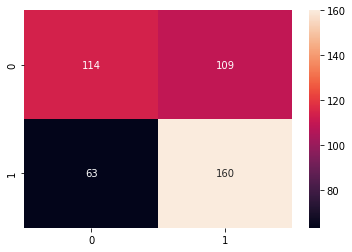

In [11]:
# pegar melhor modelo das florestas isoladas

best_model_if = IsolationForest(n_estimators=125,
                                max_samples=375,
                                contamination=0.5,
                                max_features=10,
                                bootstrap=1
                               ).fit(norm_X_train)

#################################

# salvar o modelo no disco
#pickle.dump(grid_if, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_if_predictions = best_model_if.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions[grid_if_predictions == 1] = 0
grid_if_predictions[grid_if_predictions == -1] = 1

print('\nAcuracia:', accuracy_score(y_test, grid_if_predictions))
print('Precisao:', precision_score(y_test, grid_if_predictions))
print('Recall:', recall_score(y_test, grid_if_predictions))
print('F1-score:', f1_score(y_test, grid_if_predictions))
#print(confusion_matrix(y_teste,grid_if_predictions))
#print(classification_report(y_test, grid_if_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_if_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

In [12]:
######### DADOS PAMPULHA

# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_csv('dataset_pampulha_filtro_nuvem.csv', delimiter=';')
#df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = data.dropna()
# filtrar so para bandas e classe
df_pampulha = df_filtro[['B1','B2','B3','B4','B5','B6','B7','B8','B8a','B9','B11','B12']]
#renomear para ficar igual os nomes das colunas
df_pampulha.rename(columns={'B1': 'BAND_1', 'B2': 'BAND_2', 'B3': 'BAND_3', 'B4': 'BAND_4', 'B5': 'BAND_5', 
                            'B6': 'BAND_6', 'B7': 'BAND_7', 'B8': 'BAND_8', 'B8a': 'BAND_8A', 'B9': 'BAND_9', 
                            'B11': 'BAND_11', 'B12': 'BAND_12'}, inplace=True)
#df['Classe'] = df['Classe'] - 1
# adicionar nova coluna com classe 1 pq pampulha eh anomalia
df_pampulha['Classe'] = 1
#df_pampulha

In [13]:
######### DADOS TRES MARIAS

# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_csv('turbidez_dados_globais.csv', delimiter=';')
df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()

df_dominios = df_filtro.loc[(data['Dominio'] == 'PMQs') | (data['Dominio'] == 'Campo_Geo') | (data['Dominio'] == 'Campo_Limnologia')]

# filtrar so para bandas e classe
df_tres_marias = df_dominios[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12']]
df_tres_marias['Classe'] = 0
#df_tres_marias

In [14]:
# pegar 940 amostras aleatorias da pampulha

df_pampulha_menor = df_pampulha.sample(n = 940)
df_pampulha_menor

# concatenar datasets para teste

data_teste = pd.concat([df_tres_marias, df_pampulha_menor])
#data_teste

In [15]:
# separar entrada e rotulo do treino e teste
X_data_teste = data_teste.to_numpy()[:,:12]
y_data_teste = data_teste.to_numpy()[:,12].astype(int)

# normalizar
norm_X_data_teste = scaler.fit_transform(X_data_teste)


Acuracia: 0.6622340425531915
Precisao: 0.7787934186471663
Recall: 0.4531914893617021
F1-score: 0.5729657027572292


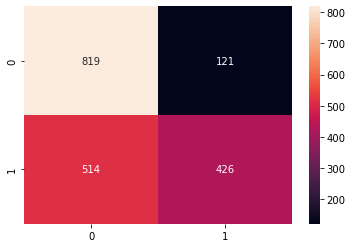

In [16]:
# testar
grid_if_predictions = best_model_if.predict(norm_X_data_teste)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions[grid_if_predictions == 1] = 0
grid_if_predictions[grid_if_predictions == -1] = 1

print('\nAcuracia:', accuracy_score(y_data_teste, grid_if_predictions))
print('Precisao:', precision_score(y_data_teste, grid_if_predictions))
print('Recall:', recall_score(y_data_teste, grid_if_predictions))
print('F1-score:', f1_score(y_data_teste, grid_if_predictions))
#print(confusion_matrix(y_teste,grid_if_predictions))
#print(classification_report(y_test, grid_if_predictions))

# matrix de confusao
cm = confusion_matrix(y_data_teste, grid_if_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

# SVM One Class

Melhores hiperparametros do modelo: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.01}

Acuracia:  0.4658385093167702
              precision    recall  f1-score   support

           0       0.48      0.77      0.59       161
           1       0.41      0.16      0.23       161

    accuracy                           0.47       322
   macro avg       0.45      0.47      0.41       322
weighted avg       0.45      0.47      0.41       322



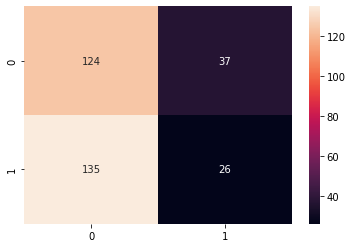

In [31]:
# treinar svm

# pesquisa em grade
param_grid_svm = {'gamma': ['scale', 'auto'],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'nu': [0.01, 0.1, 0,5, 1]}

#grid_svm = OneClassSVM(gamma='scale', nu=0.01) #GridSearchCV(SVC(),param_grid_svm,refit=True, n_jobs=-1)
grid_svm = GridSearchCV(OneClassSVM(),param_grid_svm, refit=True, scoring="recall", n_jobs=-1)
grid_svm.fit(norm_X_train)

print('Melhores hiperparametros do modelo:', grid_svm.best_params_)

#################################

# salvar o modelo no disco
#pickle.dump(grid_svm, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_svm_predictions = grid_svm.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_svm_predictions[grid_svm_predictions == 1] = 0
grid_svm_predictions[grid_svm_predictions == -1] = 1

print('\nAcuracia: ', accuracy_score(y_test, grid_svm_predictions))
#print(confusion_matrix(y_teste,grid_svm_predictions))
print(classification_report(y_test, grid_svm_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_svm_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

In [32]:
grid_svm_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [33]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Florestas isoladas

Melhores hiperparametros do modelo: {'bootstrap': True, 'contamination': 0.001, 'max_features': 5, 'max_samples': 100, 'n_estimators': 100}

Acuracia:  0.5031055900621118
              precision    recall  f1-score   support

           0       0.50      0.99      0.67       161
           1       0.67      0.01      0.02       161

    accuracy                           0.50       322
   macro avg       0.58      0.50      0.35       322
weighted avg       0.58      0.50      0.35       322



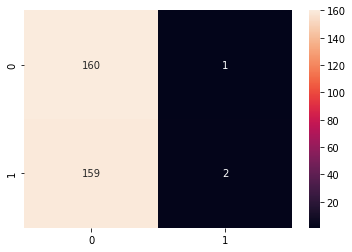

In [29]:
from sklearn.ensemble import IsolationForest

# treinar florestas isoladas

# pesquisa em grade
param_grid_if = {'n_estimators': list(range(100, 800, 5)), 
              'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False]}

grid_if = GridSearchCV(IsolationForest(), param_grid_if, refit=True, scoring="precision", n_jobs=-1)
grid_if.fit(norm_X_train)

print('Melhores hiperparametros do modelo:', grid_if.best_params_)

#################################

# salvar o modelo no disco
#pickle.dump(grid_if, open(data_salvar_modelo+'_svm_com_cluster.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_if_predictions = grid_if.predict(norm_X_test)

# Inlier Prediction: +1
# Outlier Prediction: -1
grid_if_predictions[grid_if_predictions == 1] = 0
grid_if_predictions[grid_if_predictions == -1] = 1

print('\nAcuracia: ', accuracy_score(y_test, grid_if_predictions))
#print(confusion_matrix(y_teste,grid_if_predictions))
print(classification_report(y_test, grid_if_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_if_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')